In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pd.options.display.max_columns = 100
sns.set_style('white')

In [2]:
df = pd.read_csv('Data/census_income_2019.csv', compression = 'zip')
df.head()

,PWGTP,WGTP,PINCP,WKHP,WAGP,AGEP,FER,COW,CPLT,CIT,POBP,PARTNER,SEX,RAC1P,SCHL,OCCP,NAICSP,SERIALNO,SPORDER,WAOB
0,71,0,63000,80,63000,35,0,1,0,1,18,-1,1,1,17,6250,23,2019GQ0000001,1,1
1,67,0,0,0,0,25,0,0,0,1,48,-1,1,1,12,9,-1,2019GQ0000004,1,1
2,24,0,2000,15,2000,21,2,2,0,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1,4
3,52,0,0,0,0,49,0,1,0,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1,1
4,28,0,6000,15,6000,18,2,1,0,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1,1


In [3]:
df.shape

(3239553, 20)

##### Update Column Names

In [4]:
org_vars = """PINCP
WAGP
INTP
ADJINC
PWGTP
OCCP
NAICSP
WKHP
AGEP
SEX
FER
CPLT
PARTNER
COW
RAC1P
POBP
CIT
SCHL
DIS
SERIALNO
SPORDER
WAOB""".split("\n")

In [5]:
uptd_vars = """INCOME
SALARY
INTEREST_DIV
ADJINC
FNLWGT
OCCUPATION
WORK_INDUSTRY
WKLY_HRS
AGE
SEX
MOM
COUPLE
PARTNER
WORK_CLASS
RACE
POB_DETAIL
CITIZENSHIP
EDUCATION
DIS
SERIALNO
PERSON_NO
POB_WORLD""".split("\n")

In [6]:
vars_dict = dict(zip(org_vars, uptd_vars))

In [7]:
df = df.rename(columns=vars_dict)
df.head() #Sanity Check

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,SERIALNO,PERSON_NO,POB_WORLD
0,71,0,63000,80,63000,35,0,1,0,1,18,-1,1,1,17,6250,23,2019GQ0000001,1,1
1,67,0,0,0,0,25,0,0,0,1,48,-1,1,1,12,9,-1,2019GQ0000004,1,1
2,24,0,2000,15,2000,21,2,2,0,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1,4
3,52,0,0,0,0,49,0,1,0,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1,1
4,28,0,6000,15,6000,18,2,1,0,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1,1


In [8]:
#checking for duplicates
df.duplicated().sum()

0

In [9]:
##Remove unnecessary columns
df = df.drop(['SERIALNO', 'PERSON_NO'], axis=1)

# Data Cleaning

In [10]:
# narrow down data to adults over the 17 years old
df = df[df.AGE > 17]

# narrow down data to adults who worked in the past 12 months
df = df[df.WKLY_HRS > 0]

In [11]:
df.describe()

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,POB_WORLD
count,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06
mean,1.033513e+02,9.579058e+01,6.058823e+04,3.839128e+01,5.189937e+04,4.390527e+01,5.906477e-01,2.103359e+00,8.639788e-01,1.519284e+00,6.538772e+01,2.079902e-01,1.478681e+00,1.873518e+00,1.871658e+01,4.088068e+03,1.451513e+00
std,9.061065e+01,8.493126e+01,7.691692e+04,1.310493e+01,6.724644e+04,1.525340e+01,9.042176e-01,1.827131e+00,8.056928e-01,1.227446e+00,9.273321e+01,8.872759e-01,4.995454e-01,2.079837e+00,3.274921e+00,2.685733e+03,1.123796e+00
min,1.000000e+00,0.000000e+00,-1.020000e+04,1.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00
25%,5.100000e+01,4.800000e+01,2.100000e+04,3.500000e+01,1.450000e+04,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,2.040000e+03,1.000000e+00
50%,7.900000e+01,7.400000e+01,4.024000e+04,4.000000e+01,3.540000e+04,4.400000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01,4.110000e+03,1.000000e+00
75%,1.230000e+02,1.160000e+02,7.200000e+04,4.200000e+01,6.500000e+04,5.600000e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,4.800000e+01,0.000000e+00,2.000000e+00,1.000000e+00,2.100000e+01,5.740000e+03,1.000000e+00
max,2.408000e+03,2.377000e+03,1.629000e+06,9.900000e+01,7.170000e+05,9.600000e+01,2.000000e+00,8.000000e+00,4.000000e+00,5.000000e+00,5.540000e+02,4.000000e+00,2.000000e+00,9.000000e+00,2.400000e+01,9.830000e+03,8.000000e+00


#### Checking relationships between features before feature creation

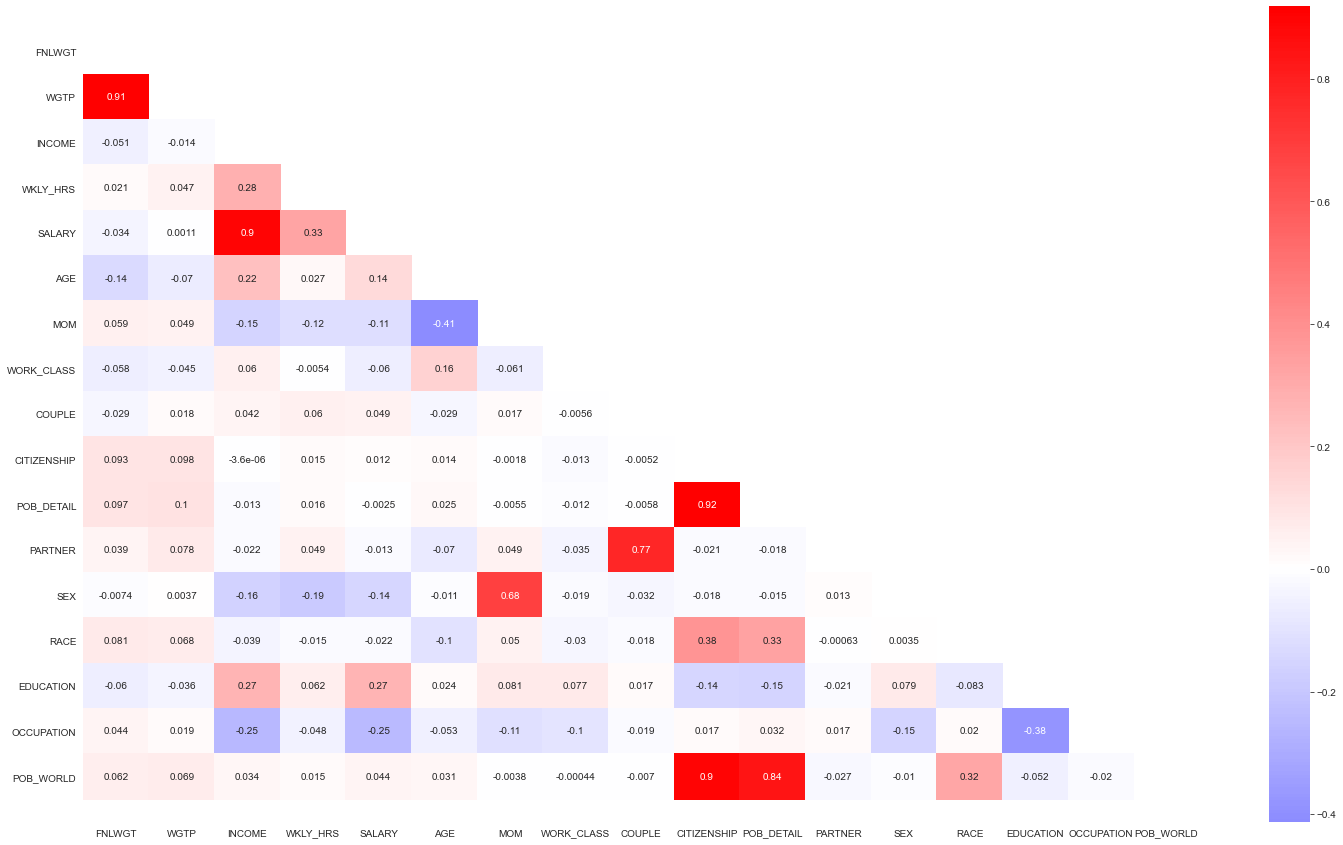

In [12]:
#create a heatmap to visualize the correlations
fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

## Feature Creation

### **CITIZENSHIP**

In [13]:
# Create new column - 1 indicating born in US, 0 indicating born outside of US
df['CITIZENSHIP_BIN'] = np.where(df['CITIZENSHIP']==1 , 1, 0)

### **EDUCATION**

In [14]:
conditions = [ 
    (df['EDUCATION'] <= 15), # Undergraduate
    ((df['EDUCATION'] >= 16) & (df['EDUCATION'] <= 19)), # High School graduate without college degree
    (df['EDUCATION'] == 20), # Associate's Degree
    (df['EDUCATION'] == 21), # Bachelor's Degree
    (df['EDUCATION'] == 22), # Master's Degree
    (df['EDUCATION'] == 23), # Professional degree beyond Master's
    (df['EDUCATION'] == 24), # Doctorate Degree 
]

choices = [
    "No High School Diploma or GED",
    'High School', 
    "Associate's", 
    "Bachelor's",
    "Master's", 
    "Professional Other", 
    "Doctorate", 
]

df['EDUCATION'] = np.select(conditions, choices, default='NA')


In [15]:
# Sanity Check
print('Count:')
print(df.EDUCATION.value_counts())
print('-'*40)
print('Proportion:')
print(df.EDUCATION.value_counts(normalize=True))

Count:
High School                      769592
Bachelor's                       378817
Master's                         166793
Associate's                      154487
No High School Diploma or GED    118434
Professional Other                42571
Doctorate                         29033
Name: EDUCATION, dtype: int64
----------------------------------------
Proportion:
High School                      0.463686
Bachelor's                       0.228241
Master's                         0.100494
Associate's                      0.093080
No High School Diploma or GED    0.071358
Professional Other               0.025649
Doctorate                        0.017493
Name: EDUCATION, dtype: float64


### **RACE**

*White/Non-White*

In [16]:
#Creating a new feature RACE2
conditions = [ 
    (df['RACE'] == 1), # White
    (df['RACE'] <= 19)] # Non-White

choices = ["White","Non-White"]

df['RACE2'] = np.select(conditions, choices, default='NA')


In [17]:
# Sanity Check
print('Count:')
print(df.RACE2.value_counts())
print('-'*40)
print('Proportion:')
print(df.RACE2.value_counts(normalize=True))

Count:
White        1296635
Non-White     363092
Name: RACE2, dtype: int64
----------------------------------------
Proportion:
White        0.781234
Non-White    0.218766
Name: RACE2, dtype: float64


*White, Black, Asian, Native American, Other*

In [18]:
#Creating a new feature RACE3
conditions = [ 
    (df['RACE'] == 1), # White
    (df['RACE'] == 2), # Black
    (df['RACE'] == 6), # Asian
    ((df['RACE'] == 3)|(df['RACE'] == 4)|(df['RACE'] == 5)|(df['RACE'] == 7)), # Native American
    ((df['RACE'] == 8)|(df['RACE'] == 9)) # Other
]
choices = ['White',
           'Black',
           'Asian',
           'Native American',
           'Other']

df['RACE3'] = np.select(conditions, choices, default='NA')

In [19]:
# Sanity Check
print('Count:')
print(df.RACE3.value_counts())
print('-'*40)
print('Proportion:')
print(df.RACE3.value_counts(normalize=True))

Count:
White              1296635
Black               143878
Other               101755
Asian               100462
Native American      16997
Name: RACE3, dtype: int64
----------------------------------------
Proportion:
White              0.781234
Black              0.086688
Other              0.061308
Asian              0.060529
Native American    0.010241
Name: RACE3, dtype: float64


### **AGE**

*Create a new feature indicating "older than 65"

In [20]:
# #Creating a new feature AGE_DIV
# conditions = [ 
#     (df['AGE'] <= 65),
#     (df['AGE'] > 65)
# ]

# choices = ['0',
#            '1'
# ]
# df['Over_65'] = np.select(conditions, choices, default='NA')

In [21]:
df['OVER_65'] = np.where(df['AGE'] >= 65, 1, 0)

In [22]:
# Sanity Check
df.OVER_65.value_counts()

0    1510977
1     148750
Name: OVER_65, dtype: int64

### **OCCUPATION**

In [23]:
# Binning Occupations

conditions = [ 
    ((df['OCCUPATION'] >= 10) & (df['OCCUPATION'] <= 440)), #MGR
    ((df['OCCUPATION'] >= 500) & (df['OCCUPATION'] <= 750)), #BUS
    ((df['OCCUPATION'] >= 800) & (df['OCCUPATION'] <= 960)), #FIN
    ((df['OCCUPATION'] >= 1005) & (df['OCCUPATION'] <= 1240)), #CMM
    ((df['OCCUPATION'] >= 1305) & (df['OCCUPATION'] <= 1560)), #ENG
    ((df['OCCUPATION'] >= 1600) & (df['OCCUPATION'] <= 1980)), #SCI
    ((df['OCCUPATION'] >= 2001) & (df['OCCUPATION'] <= 2060)), #CMS 
    ((df['OCCUPATION'] >= 2100) & (df['OCCUPATION'] <= 2180)), #LGL
    ((df['OCCUPATION'] >= 2205) & (df['OCCUPATION'] <= 2555)), #EDU
    ((df['OCCUPATION'] >= 2600) & (df['OCCUPATION'] <= 2920)), #ENT 
    ((df['OCCUPATION'] >= 3000) & (df['OCCUPATION'] <= 3550)), #MED
    ((df['OCCUPATION'] >= 3610) & (df['OCCUPATION'] <= 3655)), #HLS
    ((df['OCCUPATION'] >= 3700) & (df['OCCUPATION'] <= 3960)), #PRT 
    ((df['OCCUPATION'] >= 4000) & (df['OCCUPATION'] <= 4160)), #EAT
    ((df['OCCUPATION'] >= 4200) & (df['OCCUPATION'] <= 4255)), #CLN
    ((df['OCCUPATION'] >= 4330) & (df['OCCUPATION'] <= 4655)), #PRS
    ((df['OCCUPATION'] >= 4700) & (df['OCCUPATION'] <= 4965)), #SAL
    ((df['OCCUPATION'] >= 5000) & (df['OCCUPATION'] <= 5940)), #OFF
    ((df['OCCUPATION'] >= 6005) & (df['OCCUPATION'] <= 6130)), #FFF
    ((df['OCCUPATION'] >= 6200) & (df['OCCUPATION'] <= 6765)), #CON
    ((df['OCCUPATION'] >= 6800) & (df['OCCUPATION'] <= 6950)), #EXT
    ((df['OCCUPATION'] >= 7000) & (df['OCCUPATION'] <= 7640)), #RPR
    ((df['OCCUPATION'] >= 7700) & (df['OCCUPATION'] <= 8990)), #PRD
    ((df['OCCUPATION'] >= 9005) & (df['OCCUPATION'] <= 9760)), #TRN
    ((df['OCCUPATION'] >= 9800) & (df['OCCUPATION'] <= 9830)), #MIL
]

choices = [
    'MGR', 
    'BUS', 
    'FIN',
    'CMM', 
    'ENG', 
    'SCI',
    'CMS', 
    'LGL', 
    'EDU',
    'ENT', 
    'MED', 
    'HLS',
    'PRT', 
    'EAT', 
    'CLN',
    'PRS', 
    'SAL', 
    'OFF',
    'FFF', 
    'CON', 
    'EXT',
    'RPR',
    'PRD', 
    'TRN', 
    'MIL',
]

df['OCCUPATION'] = np.select(conditions, choices, default='NA')

In [24]:
# df.OCCUPATION.value_counts() #Sanity Check

### **WORK_INDUSTRY**

In [25]:
# Removing letters from values 
df['WORK_INDUSTRY'] = df.WORK_INDUSTRY.apply(
    lambda x: ''.join([num for num in x if num.isnumeric()]))


In [26]:
# Taking care of extraneous data
df['WORK_INDUSTRY'] = df['WORK_INDUSTRY'].apply(
    lambda x:'99' if '9281' in x else x)


In [27]:
def first_2_digits(num):
    return int(num[:2])
df['WORK_INDUSTRY'] = df.WORK_INDUSTRY.apply(first_2_digits).sort_values()


In [28]:
# Binning Industry

conditions = [ 
    (df['WORK_INDUSTRY'] == 11), #AGR
    (df['WORK_INDUSTRY'] == 21), #EXT
    (df['WORK_INDUSTRY'] == 22), #UTL
    (df['WORK_INDUSTRY'] == 23), #CON
    ((df['WORK_INDUSTRY'] >= 30) & (df['WORK_INDUSTRY'] <= 33)| (df['WORK_INDUSTRY'] == 3)), #MFG  ADD 3
    ((df['WORK_INDUSTRY'] == 42) | (df['WORK_INDUSTRY'] == 4)), #WHL
    ((df['WORK_INDUSTRY'] >= 44) & (df['WORK_INDUSTRY'] <= 45)), #RET ADD 4
    ((df['WORK_INDUSTRY'] >= 48) & (df['WORK_INDUSTRY'] <= 49)), #TRN
    (df['WORK_INDUSTRY'] == 51), # INF
    ((df['WORK_INDUSTRY'] >= 52) & (df['WORK_INDUSTRY'] <= 53)), # FIN
    ((df['WORK_INDUSTRY'] >= 54) & (df['WORK_INDUSTRY'] <= 56)), #PRF
    (df['WORK_INDUSTRY'] == 61), #EDU
    (df['WORK_INDUSTRY'] == 62), #MED/SCA
    ((df['WORK_INDUSTRY'] >= 71) & (df['WORK_INDUSTRY'] <= 72)), #ENT
    (df['WORK_INDUSTRY'] == 81), # SRV
    ((df['WORK_INDUSTRY'] >= 921) & (df['WORK_INDUSTRY'] <= 923)), #ADM
    (df['WORK_INDUSTRY'] == 99), #MIL
]

choices = [
    'AGR',
    'EXT',
    'UTL',
    'CON',
    'MFG',
    'WHL',
    'RET',
    'TRN',
    'INF',
    'FIN',
    'PRF',
    'EDU',
    'MED',
    'ENT',
    'SRV',
    'ADM',
    'MIL'
]

df['WORK_INDUSTRY'] = np.select(conditions, choices, default='NA')

**Checking out features after engineering**

# Exploring Target Variable

In [30]:
df['TARGET'] = np.where(df.INCOME > 65000, '>65k', '<=65k')
df.TARGET.value_counts()

<=65k    1183289
>65k      476438
Name: TARGET, dtype: int64

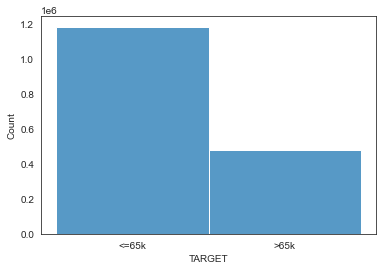

In [31]:
sns.histplot(data = df, x="TARGET")
plt.show()

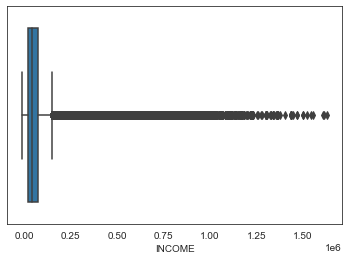

In [32]:
sns.boxplot(x=df.INCOME)


In [33]:
df.INCOME.describe()

count    1.659727e+06
mean     6.058823e+04
std      7.691692e+04
min     -1.020000e+04
25%      2.100000e+04
50%      4.024000e+04
75%      7.200000e+04
max      1.629000e+06
Name: INCOME, dtype: float64

In [34]:
df.INCOME

0           63000
2            2000
4            6000
11           3200
13            500
            ...  
3239548    150000
3239549     27000
3239550     75000
3239551     57000
3239552     55000
Name: INCOME, Length: 1659727, dtype: int64

In [35]:
df[df.INCOME > 100]['INCOME'].describe()

count    1.656282e+06
mean     6.071761e+04
std      7.694438e+04
min      1.040000e+02
25%      2.100000e+04
50%      4.050000e+04
75%      7.200000e+04
max      1.629000e+06
Name: INCOME, dtype: float64

In [36]:
df.SALARY.describe()

count    1.659727e+06
mean     5.189937e+04
std      6.724644e+04
min      0.000000e+00
25%      1.450000e+04
50%      3.540000e+04
75%      6.500000e+04
max      7.170000e+05
Name: SALARY, dtype: float64

# Additional EDA

In [37]:
df.EDUCATION.value_counts()

High School                      769592
Bachelor's                       378817
Master's                         166793
Associate's                      154487
No High School Diploma or GED    118434
Professional Other                42571
Doctorate                         29033
Name: EDUCATION, dtype: int64

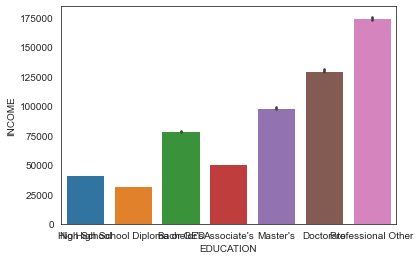

In [38]:
sns.barplot(data=df, x='EDUCATION', y='INCOME')

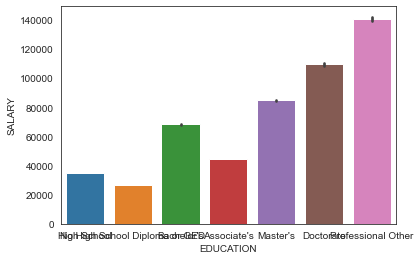

In [39]:
sns.barplot(data=df, x='EDUCATION', y='SALARY')

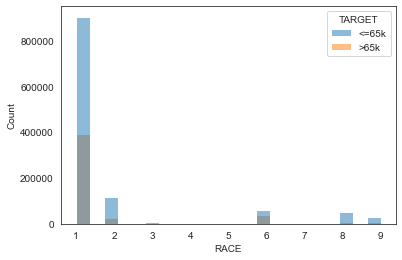

In [40]:
sns.histplot(data = df, x="RACE", hue = "TARGET")
plt.show()

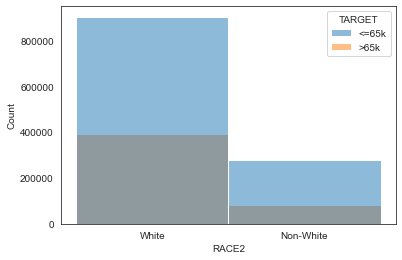

In [41]:
# 0: non-white, 1: white
sns.histplot(data = df, x="RACE2", hue = "TARGET")
plt.show()

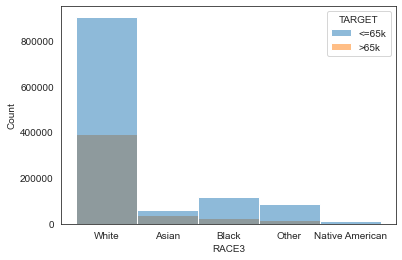

In [42]:
# Groups: White, Black, , Asian, American Indian, Other
sns.histplot(data = df, x="RACE3", hue = "TARGET")
plt.show()

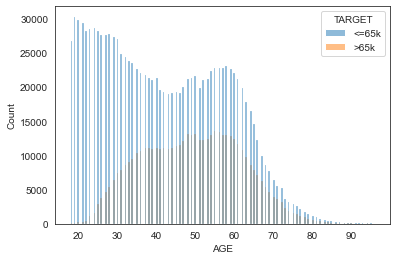

In [43]:
sns.histplot(data = df, x="AGE", hue = "TARGET")
plt.show()

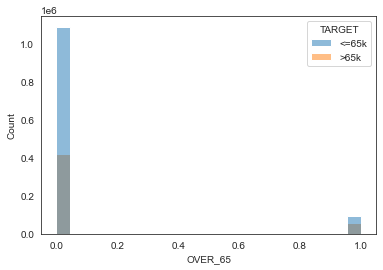

In [44]:
sns.histplot(data = df, x="OVER_65", hue = "TARGET")
plt.show()

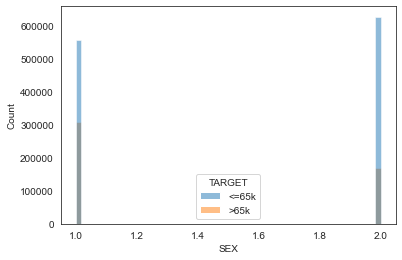

In [45]:
sns.histplot(data = df, x="SEX", hue = "TARGET")
plt.show()

In [46]:
df.SEX.value_counts(normalize=True)

1    0.521319
2    0.478681
Name: SEX, dtype: float64

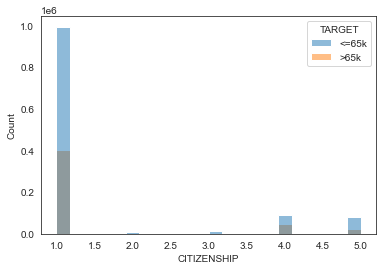

In [47]:
sns.histplot(data = df, x="CITIZENSHIP", hue = "TARGET")
plt.show()

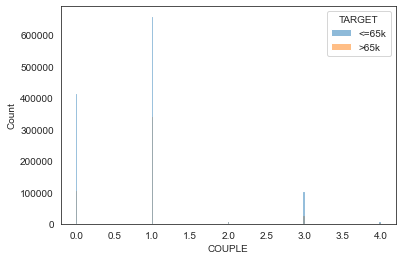

In [48]:
sns.histplot(data = df, x="COUPLE", hue = "TARGET")
plt.show()

- 1 - Opposite-sex husband/wife/spouse household
- 2 - Same-sex husband/wife/spouse household
- 3 - Opposite-sex unmarried partner household
- 4 - Same-sex unmarried partner household

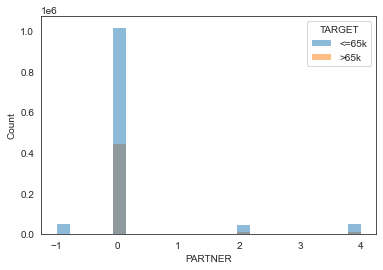

In [49]:
sns.histplot(data = df, x="PARTNER", hue = "TARGET")
plt.show()

- -1 - N/A (GQ/vacant)
- 0	- No unmarried partner in household
- 1	- Male householder, male partner
- 2	- Male householder, female partner
- 3	- Female householder, female partner
- 4	- Female householder, male partner

In [50]:
df.PARTNER.value_counts(normalize=True)

 0    0.884924
 4    0.038762
 2    0.038427
-1    0.033240
 3    0.002341
 1    0.002305
Name: PARTNER, dtype: float64

In [51]:
# sns.histplot(data = df, x="POB_WORLD", hue = "TARGET_60")

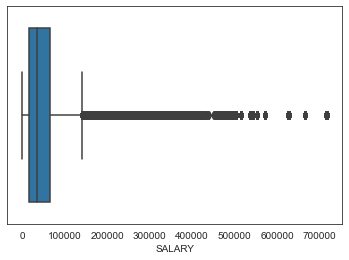

In [52]:
sns.boxplot(x=df.SALARY)


In [53]:
df.INCOME.median()

40240.0

In [54]:
df.SALARY.median()

35400.0

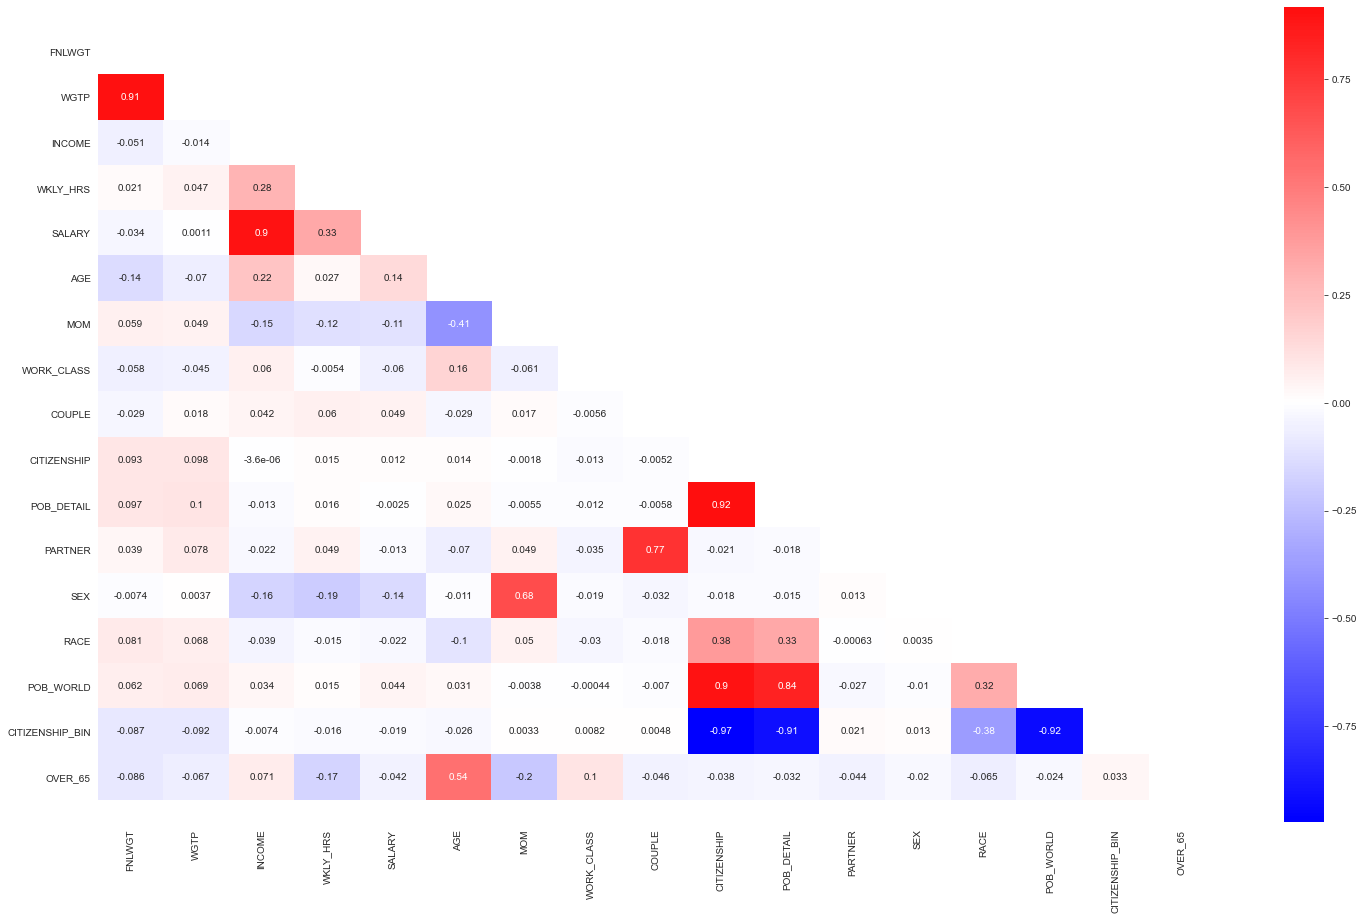

In [55]:
#Checking correlations heatmap for added features

fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

# Prepare Data for Modeling
- LabelEncoder for non-numeric features
- Remove unnecessary variables


In [56]:
le = LabelEncoder()
cols = ['OCCUPATION', 'WORK_INDUSTRY', 'EDUCATION', 'RACE2', 'RACE3',]
df.loc[:,cols] = df.loc[:,cols].apply(le.fit_transform)

In [57]:
X = df.drop(['TARGET','INCOME', 'SALARY'], axis=1)
y = df.TARGET

In [58]:
df.head(2) #Sanity Check

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,POB_WORLD,CITIZENSHIP_BIN,RACE2,RACE3,OVER_65,TARGET
0,71,0,63000,80,63000,35,0,1,0,1,18,-1,1,1,3,4,1,1,1,1,4,0,<=65k
2,24,0,2000,15,2000,21,2,2,0,5,229,-1,2,6,3,23,2,4,0,0,0,0,<=65k


# Model Testing

## Baseline Model

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [104]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [105]:
tree_score = accuracy_score(y_test, y_pred)

In [106]:
tree_score

0.7548128368021748

In [107]:
importance = tree.feature_importances_
feat_imp_dict = dict(zip(X.columns, importance))

In [108]:
feat_imp_dict

{'FNLWGT': 0.11824306148318363,
 'WGTP': 0.1175753642060787,
 'WKLY_HRS': 0.12855730729515835,
 'AGE': 0.155116624946187,
 'MOM': 0.0042102520110447435,
 'WORK_CLASS': 0.03146740129278706,
 'COUPLE': 0.019455559598427454,
 'CITIZENSHIP': 0.005432342253002101,
 'POB_DETAIL': 0.10833409221185729,
 'PARTNER': 0.0076736483225188215,
 'SEX': 0.01983983413732618,
 'RACE': 0.009623513116060516,
 'EDUCATION': 0.06780065581531149,
 'OCCUPATION': 0.10925660216716102,
 'WORK_INDUSTRY': 0.07226884202156665,
 'POB_WORLD': 0.005871943355604639,
 'CITIZENSHIP_BIN': 0.0015271722501934528,
 'RACE2': 0.003765537314357378,
 'RACE3': 0.010060682856345543,
 'OVER_65': 0.003919563345827963}

## Decision Tree and GridSearch

In [85]:
dt = DecisionTreeClassifier()
dt_param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [8, 9, 10, 11],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8]
}

In [86]:
dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=3, verbose=True, n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 75.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 9, 10, 11],
                         

In [88]:
dt_grid_search.score(X_test, y_test)

0.8079468443021989

In [74]:
dt_ = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2, min_samples_leaf = 1)
dt_.fit(X_train, y_train)


DecisionTreeClassifier()

In [73]:
def plot_feature_imporances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize = (8,8))
    plt.barh(range(n_features), model.feature_importances_, align = 'center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

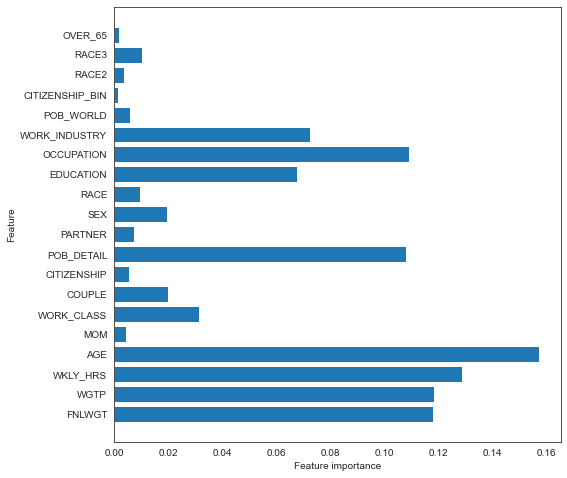

In [75]:
plot_feature_imporances(dt_)

## RandomForest

In [109]:
rf_clf = RandomForestClassifier(criterion= 'gini', n_estimators=100, min_samples_leaf=6, min_samples_split=5)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=6, min_samples_split=5)

In [110]:
rf_y_pred = rf_clf.predict(X_test)

In [111]:
rf_clf_score = accuracy_score(y_test, y_pred)

In [112]:
rf_clf_score

0.7548128368021748

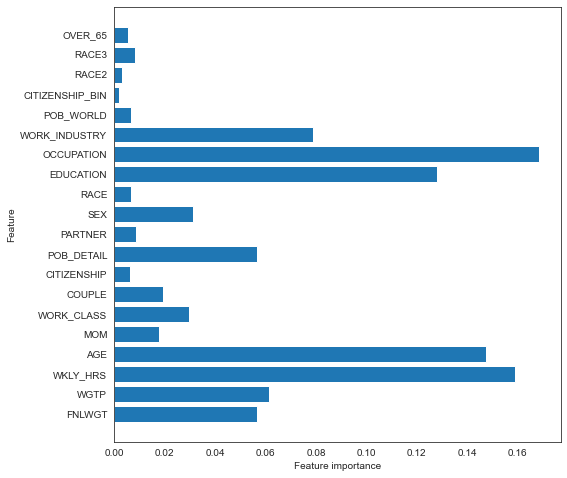

In [102]:
plot_feature_imporances(rf_clf)

## Model Evaluation Summary

In [89]:
print("Decision tree accuracy score", tree_score)
print("Random forest accuracy score", rf_clf_score)

Decision tree accuracy score 0.7543934909816549
Random forest accuracy score 0.8249231199329047


##### best model evaluation

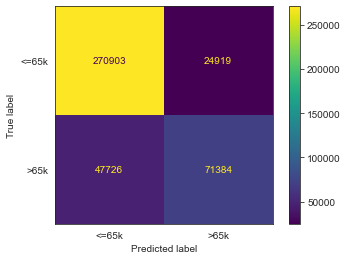

In [93]:
plot_confusion_matrix(rf_clf, X_test, y_test)